Based on [https://docs.opencv.org/3.3.1/dd/d12/tutorial_omnidir_calib_main.html](https://docs.opencv.org/3.3.1/dd/d12/tutorial_omnidir_calib_main.html)

API documentation: [cv2.omnidir.undistortImage()](https://docs.opencv.org/3.4.2/d3/ddc/group__ccalib.html#gafe4f53d9b64bfe15b86e75a4699cbba4)

Source code: [omnidir.cpp](https://github.com/opencv/opencv_contrib/blob/master/modules/ccalib/src/omnidir.cpp)

In [1]:
import cv2
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import yaml

In [2]:
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = [15, 15]

In [3]:
def plot(img):
    new_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(new_img);

In [4]:
def read_ucm_params_camodocal(filename):
    with open(filename, 'r') as stream:
        skip_lines = 2
        for i in range(skip_lines):
            _ = stream.readline()
        try:
            data = yaml.safe_load(stream)
        except yaml.YAMLError as exc:
            print(exc)
    dp = data['distortion_parameters']
    D = np.array([dp['k1'], dp['k2'], dp['p1'], dp['p2']])
    pp = data['projection_parameters']
    K = np.eye(3)
    K[0][0] = pp['gamma1']
    K[1][1] = pp['gamma2']
    K[0][2] = pp['u0']
    K[1][2] = pp['v0']
    xi = np.array([data['mirror_parameters']['xi']])
    return xi, K, D

In [5]:
def read_ucm_params_kalibr(filename):
    with open(filename, 'r') as stream:
        try:
            data = yaml.safe_load(stream)
        except yaml.YAMLError as exc:
            print(exc)
    dp = data['cam0']['distortion_coeffs']
    D = np.array(dp)
    pp = data['cam0']['intrinsics']
    K = np.eye(3)
    K[0][0] = pp[1]
    K[1][1] = pp[2]
    K[0][2] = pp[3]
    K[1][2] = pp[4]
    xi = np.array(pp[:1])
    return xi, K, D

In [6]:
def initRectifyMap(K, D, xi):
    flags = cv2.omnidir.RECTIFY_LONGLATI
    new_size = (640, 640)
    Knew = np.eye(3)
    nh = new_size[0]
    nw = new_size[1]
    Knew[0][0] = nw / 3.141592
    Knew[1][1] = nh / 3.141592
    R = np.eye(3)
    map1, map2 = cv2.omnidir.initUndistortRectifyMap(K, D, xi, R, Knew, new_size, cv2.CV_16SC2, flags)
    return map1, map2

In [7]:
def equirectangular_projection(img, map1, map2):
    img_t = cv2.transpose(img)
    img_f = cv2.flip(img_t, flipCode=1)
    undistorted_img = cv2.remap(img_f, map1, map2, cv2.INTER_LINEAR, cv2.BORDER_CONSTANT)
    img_t = cv2.transpose(undistorted_img)
    img_f = cv2.flip(img_t, flipCode=0)
    return img_f

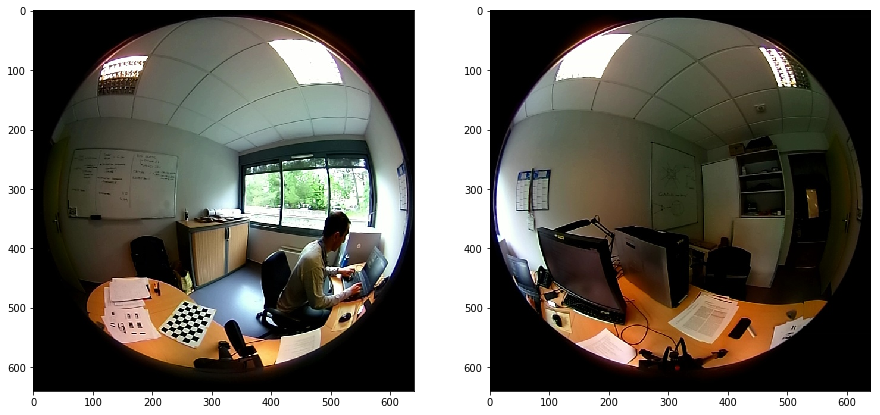

In [8]:
image_file = 'front.jpg'
front_img = cv2.imread(image_file)
plt.subplot(121); plot(front_img);
image_file = 'back.jpg'
back_img = cv2.imread(image_file)
plt.subplot(122); plot(back_img);

#### Use calibration parameters from CamOdoCal

In [9]:
params_file = '../config/front_camera_calib.yaml'
xi_f, K_f, D_f = read_ucm_params_camodocal(params_file)

In [10]:
params_file = '../config/back_camera_calib.yaml'
xi_b, K_b, D_b = read_ucm_params_camodocal(params_file)

#### Use calibration parameters from Kalibr

In [11]:
params_file = '../config/camchain-front_camera.yaml'
xi_f, K_f, D_f = read_ucm_params_kalibr(params_file)

In [12]:
params_file = '../config/camchain-back_camera.yaml'
xi_b, K_b, D_b = read_ucm_params_kalibr(params_file)

### Compute rectification map and project into equirectangular image

In [13]:
%%time
map1_f, map2_f = initRectifyMap(K_f, D_f, xi_f)
map1_b, map2_b = initRectifyMap(K_b, D_b, xi_b)

CPU times: user 154 ms, sys: 573 µs, total: 154 ms
Wall time: 154 ms


In [14]:
%%time
front_eqimg = equirectangular_projection(front_img, map1_f, map2_f)
back_eqimg = equirectangular_projection(back_img, map1_b, map2_b)
both_eqimg = np.concatenate((front_eqimg, back_eqimg), axis=1)
panorama = np.roll(both_eqimg, 320, axis=1)

CPU times: user 10.7 ms, sys: 8.99 ms, total: 19.7 ms
Wall time: 9.35 ms


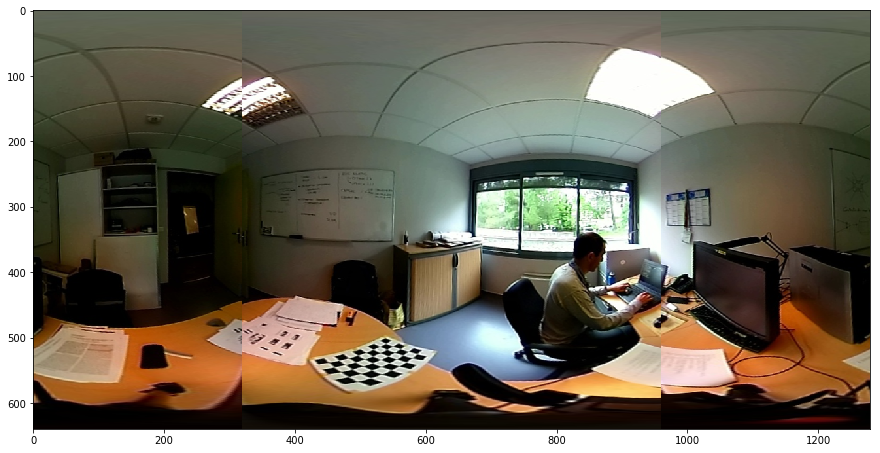

In [15]:
plot(panorama);

In [16]:
cv2.imwrite('panorama.png',panorama)

True